# Predicting StarCraft II Win Probability - Notebook 3
By: [**Jared Lloyd**](https://github.com/jared-a-lloyd/sc2-modeling)

__[Brainstation](https://brainstation.io/)__ Capstone Project

---

<center><i><b><a style="color:darkviolet;font-size:18px">How well can an independent observer predict the match outcome as the game progresses?</a></b></i></center>

# Event Data Analysis and Modeling

In this Notebook we will explore the data available in the SpawningTool event dataset.

We will analyze some of the features that are available, identify any that may have linear correlations the game outcome, and decide on how best to use this information in creating our Neural Network model.

## Table of Contents
1. [Event Data Exploration](#section-1)
    1. [Extracting Event Data](#section-1-1)
    2. [Event Data Analysis](#section-1-2)
    3. [Feature Analysis](#section-1-3)
2. [Modeling with RNN](#section-2)
    1. [Extracting the Datasets](#section-2-1)
    2. [Simple RNN Model](#section-2-2)
    3. [Modeling with Different Window Sizes](#section-2-3)
    4. [Building a Grid Search](#section-2-4)
3. [Conclusion](#section-3)

---

#### Package imports and settings
Notes:
* To deal with the size of the dataframes in this Notebook, the `pandas` max_rows and max_columns settings are set to 200. If editing any code please use `.head()` or some other limit when displaying dataframes.
* The final codeblock in the Notebook will create an error. This is a known issue, and was left in place to illustrate further work that needs to be done on this project.

In [2]:
import os
import re
from datetime import datetime, timedelta
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from scikeras.wrappers import KerasClassifier
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# other
from tqdm import tqdm
import multiprocessing as mp

#### Matplotlib settings
%matplotlib inline
import matplotlib as mpl

# specify default rcParams so that fontsize, weight and style don't need to be set each time
# Title in bold, fontsize 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20
# Plot fontsize 16 and bold
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 16
# set figure size
mpl.rcParams['figure.figsize'] = (18, 8)
# set grid on
mpl.rcParams['axes.grid'] = True
# set grid linestyle
mpl.rcParams['grid.linestyle'] = '--'
# set axis labels fontsize
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# race list and colors that will be used to represent them
RACE_LIST = [
    'Protoss',
    'Terran',
    'Zerg'
    ]
COLOR_DICT = {
    'Protoss': 'goldenrod',
    'Terran': 'firebrick',
    'Zerg': 'darkviolet'
    }

#### Pandas options
# these are set to allow better exploration of the large dataframes in this 
# notebook
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

#IPython
from IPython.display import display
%load_ext autoreload

## Section 1: Event Data Exploration <a name="section-1"></a>
In this section we will first extract the event data from the pickle files, and then explore and visualize.

### 1.1 Extracting Event Data <a name="section-1-1"></a>
Event data are stored in 3 pickle files, one each for the training, validation, and test sets. It should be noted that these files contain all games from the SpawningTool with a length between 5 and 45 minutes. No other filters were applied before saving the data to allow for the full exploration of the data. Before modeling, the required filters will be applied to the hashlists to remove any games that do not meet the criteria.

First we will extract the training event data as this is the largest dataset. We do this by running a loop that extracts each of the pickle files and saves them to a list. Then we concatenate the entire list of dataframes to a single dataframe each for training, validation and test.

In the loop we also append three new columns:
* `filehash`: The hash of the file that the event data was extracted from.
* `winner`: 1 for Player 1, 0 for Player 2.
* `frame`: The frame index of the dataframe is converted into a column. This is done to allow easy contenation without the index being changed.

At the end of the loop, the file is written to file instead of being returned to prevent memory issues.

To select which replays go into which set we will use the scikit-learn `train_test_split` function. This will allow us to use stratified sampling to ensure that the data is balanced. A list of filehashes is created for each set, and then that filehash list can be passed to `create_combined_clean_df()` to create a dataframe of all the data.

Stratification is performed by arbitrarily assigning a numerical value to each categorical variable. The array of filehashes is used as the X variable and the array of converted categorical variables is used as the y variable to allow for the specification of stratification.

First we separate training and test data using an 80/20 split. Then we separate the training data into training and validation sets using a 70/30 split.

**NOTE:** This is a very memory intensive task, for the training dataframe, memory usage peaks at around 20GB.

In [35]:
%%writefile scripts/reduce_mem_usage.py
# sourced from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

import pandas as pd
from tqdm import tqdm
import numpy as np

def reduce_mem_usage(df):
    """
    reduce_mem_usage
    Function to reduce the memory usage of a dataframe by changing the data type of each column.

    Args:
        df (pandas.DataFrame): the dataframe to be reduced

    Returns:
        pandas.DatFrame: the reduced dataframe
    """    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("\tMemory usage of dataframe is :",round(start_mem_usg,2)," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for i in tqdm(
        range(len(df.columns)), 
        desc='Processing columns', 
        unit='row'
    ):
        col = df.columns[i]
        if df[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
    
    # Print final result
    print("\t___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("\tMemory usage is: ", round(mem_usg,2)," MB")
    print("\tThis is ",round(100*mem_usg/start_mem_usg,2),"% of the initial size")
    return df, NAlist

Overwriting scripts/reduce_mem_usage.py


In [2]:
from scripts.reduce_mem_usage import reduce_mem_usage
%autoreload

# get spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

# get filehashes of replays using the following filters:
# - only replays with a winner
# - only replays between 5 and 60 minutes inclusive
filehash_list = spawningtool_df.loc[
    (spawningtool_df['game_length'] >= 5*60) & 
    (spawningtool_df['game_length'] <= 45*60) &
    (spawningtool_df['game_winner'] != 0),
    'filehash'
].tolist()

# count the total number of replays available
number_files = len(filehash_list)
print(f'{number_files} replays available')

# set the list of columns to be used in stratification
stratify_list = [
    'game_winner', 
    'game_length', 
    'player1_race', 
    'player2_race'
]

# create temp_df to allow remapping values
temp_df = spawningtool_df.loc[spawningtool_df['filehash'].isin(filehash_list)].copy()

# change categorical variables in stratify_list to numerical tokens
for col in ['player1_race', 'player2_race', 'game_length']:
    # get unique values in the column and assign a numerical value to each
    unique_values = temp_df[col].unique()

    # for game_length we will create bins, instead of using unique values
    if col == 'game_length':
        # create 4 bins for game_length, use qcut for quantile cuts
        temp_df[col] = pd.qcut(temp_df[col], 4, labels=np.arange(4))
        
        # everything below just applies to player race so continue
        continue

    # create a dictionary mapping the unique values to numerical values
    # it is not important what the actual value is, these are just for stratification
    unique_dict = {
        unique_values[i]: i for i in range(len(unique_values))
    }

    # replace the categorical values with numerical values
    temp_df[col] = temp_df[col].replace(unique_dict)


# create X array which contains only filehashes
X = temp_df['filehash'].values

# create y array with variables for concatenation
y = temp_df[stratify_list].values

# use test train split to get the filehashes for training, validation and testing
# first split test and training set 80/20
# use stratified sampling to get the filehashes for training and validation
# underscores are used because we are not interested in the actual y_test values
train_filehash_list, test_filehash_list, y_train, _ = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# now we can split the training set into training and validation
train_filehash_list, val_filehash_list, _, _ = train_test_split(
    train_filehash_list,
    y_train,
    test_size=0.3,
    random_state=42,
    stratify=y_train
)

print('-'*80)
print(f'{len(train_filehash_list)} training replays')
print(f'{len(val_filehash_list)} validation replays')
print(f'{len(test_filehash_list)} testing replays')

31941 replays available
--------------------------------------------------------------------------------
17886 training replays
7666 validation replays
6389 testing replays


Now that we have split our data into stratified training, validation and test sets, we can use the `create_combined_clean_df()` function to create a dataframe of all the data.

The returned column list will be used to create a `master_column_list` variable which tracks the names of every column found in all three dataframes.

At each step we use the `reduce_mem_usage()` function to reduce the memory usage of the dataframe. This function was sourced from __[ArjanGroen](https://www.kaggle.com/arjanso)__ on __[Kaggle](https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65)__. It works by assessing the data contained in the dataframe and reducing it the smallest type possible.

In testing it was found that the `reduce_mem_usage()` function was affecting data quality. So as not to require debugging the entire code block, it was decided not to use the function, and instead to save each replay's data as a separate `npy` file that can be loaded into memory at runtime by the `BatchGenerator()` class. The code for `reduce_mem_usage()` has been retained though, as it may be useful for future work.

In [3]:
# read all the data from the training filehashes into a list of dataframes
def create_combined_clean_df(
    filehash_list,
    replay_dir,
    metadata_df,
    output_path
):
    """
    create_combined_clean_df
    Create a dataframe that contains all the data from the clean dataframes

    Args:
        filehashes (list, str): the filehashes of the clean dataframes
        replay_dir (str): the directory where the clean dataframes are stored
        metadata_df (df): the metadata dataframe
        output_name (str): the path and filename of the output dataframe
        models_path (str): the path to the directory where the model data are stored

    Returns:
        columns_list (list, str): the list of columns in the combined dataframe
    """
    # create an empty list for the dataframes
    df_list = []

    # loop through the filehashes and read the dataframes
    for i in tqdm(
        range(len(filehash_list)),
        desc='Reading dataframes',
        unit='file'    
    ):

        # read the filehash
        filehash = filehash_list[i]
        
        # get the path to the dataframe
        path = os.path.join(replay_dir, filehash + '.zip')
        
        # if path exists
        if os.path.exists(path):
            df = pd.read_pickle(path)
        else:
            continue

        # check that df has no nans
        if df.isnull().values.any():
            continue

        # write the filehash to the df
        df['filehash'] = filehash

        # look up winner in metadata_df
        winner = metadata_df.loc[
            metadata_df['filehash'] == filehash,
            'game_winner'
        ].values[0]

        # add winner to df 1 for player 1 and 0 for player 2
        if winner == 1:
            df['winner'] = winner
        else:
            df['winner'] = 0
        
        # reset index
        df.reset_index(inplace=True)

        # rename index to 'frame'
        df.rename(columns={'index': 'frame'}, inplace=True)
        
        # append the df to the list
        df_list.append(df)

    print('-'*20)
    print('\tCombining dataframes')

    # combine the dataframes
    df_all = pd.concat(df_list, axis=0, ignore_index=True)

    # fill NaNs (new columns) with 0
    df_all.fillna(0, inplace=True)

    print('\tCombined dataframe shape:', df_all.shape)
    print('\tTotal NaN values:', df_all.isnull().sum().sum())

    # print('-'*20)
    # print('\tReducing memory usage')
    # # reduce memory usage
    # df_all, _ = reduce_mem_usage(df_all)
    # print('-'*20)

    print('\tSaving dataframe')
    # save the dataframe
    df_all.to_pickle(output_path)

    # get the columns list
    columns_list = list(df_all.columns)

    print(f'\tDone saving dataframe to {output_path}')
    print('-'*80)
    return columns_list

In [4]:
# NOTE: This cell takes a long time to run, around 30 minutes
# create a list of filehash lists for training, validation and testing
list_of_filehash_lists = [
    train_filehash_list,
    val_filehash_list,
    test_filehash_list
]

# create a list of output filenames
filenames = [
    'training_clean.zip',
    'validation_clean.zip',
    'testing_clean.zip'
]

# create a list of output paths for npy files
model_data_dir = [
    'data/model_data/train/',
    'data/model_data/val/',
    'data/model_data/test/'
]

# create empty master list of columns
master_columns_list = []

# loop through the filehash lists
for i in range(len(list_of_filehash_lists)):
    # get the filehash list
    filehash_list = list_of_filehash_lists[i]
    
    print(f'Processing item - {filenames[i]}')
    print(f'{len(filehash_list)} replays')
    print('-'*20)

    print('\tLoading files')
    # get the columns list and save the dataframe to file
    column_list = create_combined_clean_df(
        filehash_list,
        'data/clean_events',
        spawningtool_df,
        'data/' + filenames[i]
    )

    # add any new columns to the master list
    master_columns_list += [col for col in column_list if col not in master_columns_list]

print('-'*80)
print(f'{len(master_columns_list)} columns in master list')

# save the master list of columns
pd.DataFrame(master_columns_list).to_csv('info/clean_master_columns_list.csv', index=False, header=False)

Processing item - training_clean.zip
17886 replays
--------------------
	Loading files


Reading dataframes: 100%|██████████| 17886/17886 [01:03<00:00, 280.90file/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (2664520, 537)
	Total NaN values: 0
	Saving dataframe
	Done saving dataframe to data/training_clean.zip
--------------------------------------------------------------------------------
Processing item - validation_clean.zip
7666 replays
--------------------
	Loading files


Reading dataframes: 100%|██████████| 7666/7666 [00:30<00:00, 250.16file/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (1142815, 525)
	Total NaN values: 0
	Saving dataframe
	Done saving dataframe to data/validation_clean.zip
--------------------------------------------------------------------------------
Processing item - testing_clean.zip
6389 replays
--------------------
	Loading files


Reading dataframes: 100%|██████████| 6389/6389 [00:24<00:00, 262.09file/s]


--------------------
	Combining dataframes
	Combined dataframe shape: (955057, 500)
	Total NaN values: 0
	Saving dataframe
	Done saving dataframe to data/testing_clean.zip
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
581 columns in master list


### 1.2 Event Data Analysis <a name="section-1-2"></a>

From this point on the data will be loaded from the `clean_<dataset>.zip` files that we created above, where \<dataset\> is either train, val or test.

Now we should check the distribution of the data. We will check:
* The amount of wins for player 1.
* The length of games.
* The race distribution between the three datasets.


In [5]:
def build_master_columns_list(df_list):
    """
    Reads the columns from the list of dataframes and creates a master list of each unique column

    Args:
        df_list (list, df): the list of dataframes

    Returns:
        master_columns_list (list, str): the master list of columns
    """

    # create an empty list
    master_columns_list = []

    # loop through the dataframes
    for df in df_list:
        # get the columns
        columns_list = list(df.columns)

        # loop through the columns
        for col in columns_list:
            # check if the column is in the master list
            if col not in master_columns_list:
                # add the column to the master list
                master_columns_list.append(col)

    # return the master list
    return master_columns_list

In [6]:
# read in the clean_df dataframes
# read in training data
train_df = pd.read_pickle('data/training_clean.zip')
# read in validation data
val_df = pd.read_pickle('data/validation_clean.zip')
# read in test data
test_df = pd.read_pickle('data/testing_clean.zip')

# read in spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

In [7]:
# extract the respective filehashes
# training filehashes
train_filehash_list = list(train_df['filehash'].unique())
# validation filehashes
val_filehash_list = list(val_df['filehash'].unique())
# test filehashes
test_filehash_list = list(test_df['filehash'].unique())

# read the master list of columns
master_columns_list = pd.read_csv('info/clean_master_columns_list.csv', header=None).values.tolist()
# this produces a list of lists per row, convert to a single list
# loop through the list of lists and return the first element
master_columns_list = [col[0] for col in master_columns_list]

print(f'There are {len(master_columns_list)} columns in the master list')
print('-'*80+'\n')
print(f'The shape of train_df is {train_df.shape}')
print(f'The shape of val_df is {val_df.shape}')
print(f'The shape of test_df is {test_df.shape}')

There are 581 columns in the master list
--------------------------------------------------------------------------------

The shape of train_df is (2664520, 537)
The shape of val_df is (1142815, 525)
The shape of test_df is (955057, 500)


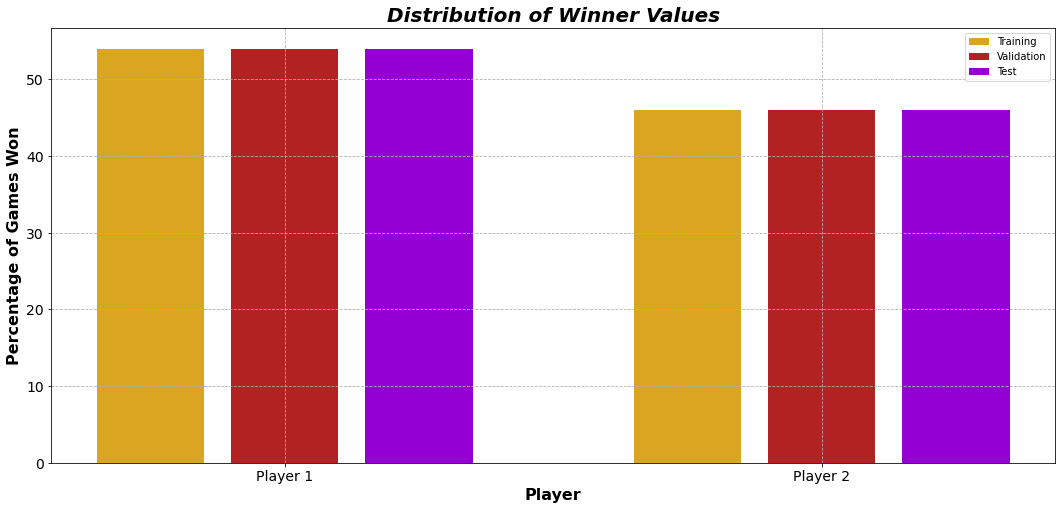

In [5]:
# plot the distribution of winner values for the three data sets
fig, ax = plt.subplots()

# set up lables for the graph
labels = ['Training', 'Validation', 'Test']

# setup list of filehash lists
list_of_filehash_lists = [
    train_filehash_list, 
    val_filehash_list, 
    test_filehash_list
]

# for offsetting the x-axis ticks
width = 0.25

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the winner values
    # scale the values by the amount of filehashes
    winners = spawningtool_df.loc[
        mask, 
        'game_winner'
    ].value_counts()/len(filehashes)*100

    # plot the distribution of the training data
    # make the bar width proportional to the number of filehashes
    plt.bar(
        winners.index - width + (i*width),
        height=winners,
        color=list(COLOR_DICT.values())[i],
        label=labels[i],
        width=width - 0.05
    )

ax.set_xticks(winners.index, ['Player 1', 'Player 2'])
plt.legend()
plt.title('Distribution of Winner Values', style='italic')
plt.xlabel('Player')
plt.ylabel('Percentage of Games Won')
plt.show()

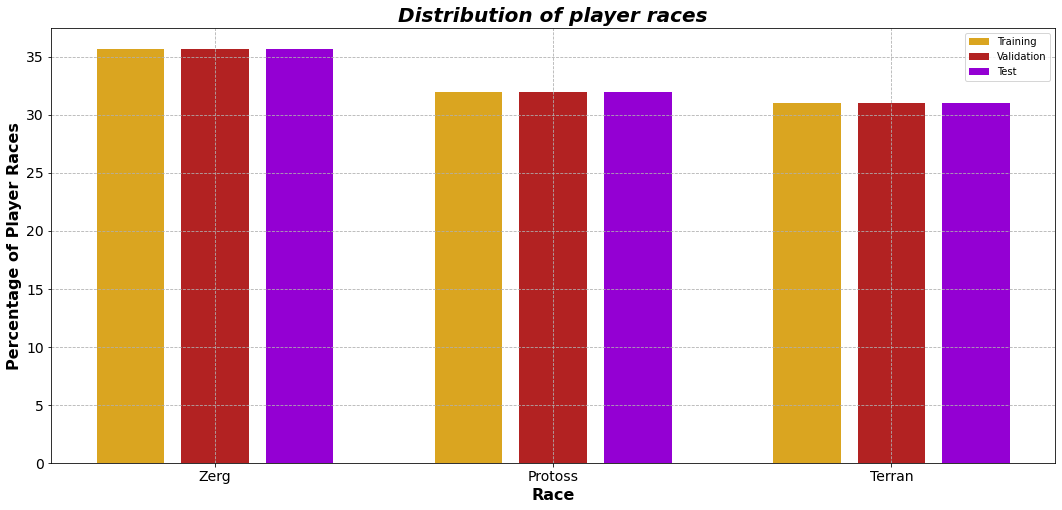

In [6]:
# plot the distribution of races for each dataset
fig, ax = plt.subplots()

x = np.arange(3)

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the count of player1 races
    race_counts = spawningtool_df.loc[
        mask, 'player1_race'
    ].value_counts()
    # add the count of player2 races
    race_counts += spawningtool_df.loc[mask, 'player2_race'].value_counts()

    # divide by the number of players
    race_counts /= len(filehashes)*2

    # plot as a bar
    plt.bar(
        x - width + i*width,
        height=race_counts.values*100,
        width=width - 0.05,
        color=list(COLOR_DICT.values())[i],
        label=labels[i]
    )

ax.set_xticks(x, race_counts.index.values)
plt.legend()
plt.title('Distribution of player races', style='italic')
plt.xlabel('Race')
plt.ylabel('Percentage of Player Races')
plt.show()
    


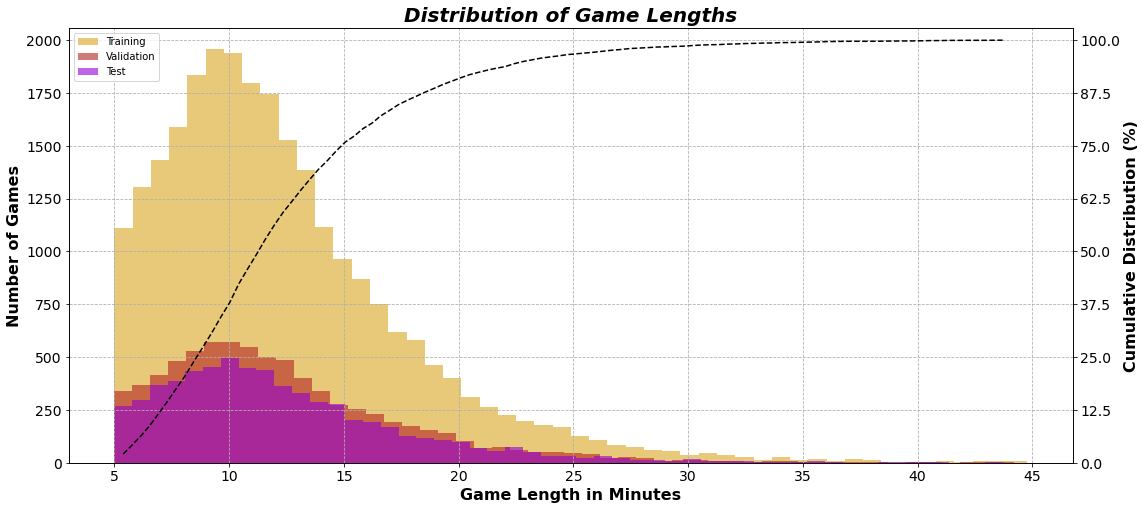

In [7]:
# plot game length 
fig, ax = plt.subplots(1,1)

for i, filehashes in enumerate(list_of_filehash_lists):
    # create a mask for the filehashes
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the game length values
    game_lengths = spawningtool_df.loc[
        mask, 'game_length'
    ]/60

    # plot the distribution of game lengths
    ax.hist(
        game_lengths,
        bins=50,
        color=list(COLOR_DICT.values())[i],
        label=labels[i],
        alpha=0.6,
        density=False
    )

ax.set_xlabel('Game Length in Minutes')
ax.set_ylabel('Number of Games')

# plot a line of cumulative distribution
# get twinx
ax2 = ax.twinx()

# get the cumulative distribution
count, bins_count = np.histogram(game_lengths, bins=100)

# calculate the probability distribution function
pdf = count / sum(count)

# calculate the cumulative distribution function
cdf = np.cumsum(pdf)*100

ax2.plot(
    bins_count[1:],
    cdf,
    color='black',
    linestyle='--',
    label='Cumulative Distribution'
)

ax2.set_ylabel('Cumulative Distribution (%)')
ax2.grid(False)

# get max value of ax.y
y_max = ax.get_ylim()[1]
# calculate ax2 ylim
y_max_2 = y_max/2000 * 100
y_min_2 = 0
ax2.set_ylim(y_min_2, y_max_2)

# scale ax2 ticks to ax.y
ax2.set_yticks(np.linspace(0, 100, 9))

ax.legend(loc=2)
plt.title('Distribution of Game Lengths', style='italic')
plt.show()


Game length, player races and game winner appear to be evenly distributed across all three datasets.
* **Game length**: As previously discussed, the bulk of games are around 10 minutes long. 75% of games are under 15 minutes in length, with a long tail extending to 45 minutes.
* **Player Race**: Zerg are most represented, followed by Protoss and then Terran.
* **Game Winner**: Game wins are fairly evenly distributed between Player 1 and Player 2, with Player 1 having 55% of victories. This should be an even enough balance so as not to bias the model.

### 1.3 Feature Analysis <a name="section-1-3"></a>
We would like to have more insight into the features to be modeled. However, with the large amount of feature columns that are present, it would be impractical to simply plot the distribution of each.

Instead we will analyze features based on the following criteria:
* Least commonly present features - features which are present (i.e. non-zero) in the least games.
* Features which correlate most strongly to game outcome - using the Pearson correlation coefficient.

These analyses will be performed on the training data, as it is the largest dataset. Due to significant memory requirements we will not combine the data for all three.

#### Ensuring all dataframes match
First we need to make sure the columns of all dataframes match. To do this we will pass each dataframe through a function that compares the columns to the `master_columns_list`. The function is defined so that later it may be used in generating data for the model.

In [8]:
# function to match columns names to the master list
def match_columns_with_master(df, master_columns_list):
    """
    Matches the columns of a dataframe to the master list of columns.
    Newly added columns are assigned a value of 0 for all rows.

    Args:
        df (df): the dataframe
        master_columns_list (list, str): the master list of columns

    Returns:
        df (df): the dataframe with the columns matched
    """

    # convert the master list to a df
    master_df = pd.DataFrame(columns=master_columns_list)

    # use pd.align to align the master df and the df
    # right join to only use the master columns list
    df, _ = df.align(master_df, join='right', axis=1, fill_value=0)

    # return the dataframe with columns arranged in the master list order
    return df[master_columns_list]

In [10]:
from scripts.reduce_mem_usage import reduce_mem_usage
%autoreload
# match the columns of the training data and reduce the size
train_df = match_columns_with_master(
        train_df, 
        master_columns_list
    )

# match the columns of the validation data
val_df =  match_columns_with_master(
        val_df,
        master_columns_list
    )

# match the columns of the test data
test_df = match_columns_with_master(
        test_df,
        master_columns_list
    )


In [11]:
print(f'The shape of train_df is {train_df.shape}')
print(f'The shape of val_df is {val_df.shape}')
print(f'The shape of test_df is {test_df.shape}')


The shape of train_df is (2664520, 581)
The shape of val_df is (1142815, 581)
The shape of test_df is (955057, 581)



#### Correlation to game outcome
Since we are interested in predicting the game outcome, we will first investigate the linear correlation between each feature and the game outcome. Only the top 20 features with negative and positive correlation will be reported.

We are using the __[Pearson R correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__ coefficient to calculate the correlation between each feature and the game outcome. Pearson's R is a measure of linear correlation between two variables, and is calculated by the following formula:
$$ \rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} $$

where $\rho$ is the Pearson correlation coefficient, $cov(X,Y)$ is the covariance between $X$ and $Y$, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$.

Covariance is calculated by calculating the difference between each value of $X$ and $Y$ and their respective means, multiplying the two, and dividing by the number of observations:
$$ cov(X,Y) = \frac{1}{n}\sum_{i=1}^{n}(X_i - \mu_X)(Y_i - \mu_Y) $$

where $n$ is the number of observations, $X_i$ is the $i$th value of $X$, $Y_i$ is the $i$th value of $Y$, $\mu_X$ is the mean of $X$, and $\mu_Y$ is the mean of $Y$.

In [11]:
# get correlation matrix for the training data
# use corrwith because we are only interested in correlating the winner column 
# with the other columns
train_corr = pd.DataFrame(
    train_df.corrwith(train_df['winner']),
    columns=['coefficient'])
train_corr.head()

,coefficient
frame,0.000349
p1_upgrade_type_name_SprayTerran,0.004215
p1_upgrade_type_name_TerranInfantryWeaponsLevel1,0.000111
p1_name_PlayerStatsEvent,-0.007506
p1_name_UnitBornEvent,0.022518


In [12]:
def plot_top_n_values(
    df, 
    column_label,
    n_values=20
):
    """
    plot_top_correlations
    --------------------------------------------------
    Plots the top and bottom n_values from the correlation matrix.

    Args:
        df (pandas.DataFrame): the correlation matrix
        column_label (str): the label of the column used to title the plot
        show_negative (bool): whether to show negative values as negative or positive
        n_values (int): the number of top correlations to plot
    """

    # get the column name
    column_name = df.columns[0]

    # get the largest n_values that are positive
    pos_df = df.nlargest(n_values, column_name).sort_values(
        by=column_name,
        ascending=False
    )
    # get the largest n_values that are negative
    neg_df = df.nsmallest(n_values, column_name).sort_values(
        by=column_name,
        ascending=False
    )

    # plotting is adapted from Boris Shabash in Brainstation Education material
    # https://www.brainstation.io/

    # setup the plot
    fig, ax = plt.subplots(2, 1, figsize=(18, 18))

    # plot the negative correlations
    neg_df.plot(
        kind='bar',
        rot=45,
        ax=ax[0],
        color=list(COLOR_DICT.values())[0])
    ax[0].set_title('Top Negative', style='italic')
    ax[0].legend().set_visible(False)
    ax[0].set_ylabel(f'{column_name} value')
    # right align the x-axis tick labels
    labels = [l.get_text() for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels, ha='right', fontsize=14)

    # plot the positive correlations
    pos_df.head(n_values).plot(
        kind='bar',
        rot=45,
        ax=ax[1],
        color=list(COLOR_DICT.values())[1])
    ax[1].set_title('Top Positive', style='italic')
    ax[1].legend().set_visible(False)
    ax[1].set_ylabel(f'{column_name} value')
    # right align the x-axis tick labels
    labels = [l.get_text() for l in ax[1].get_xticklabels()]
    ax[1].set_xticklabels(labels, ha='right', fontsize=14)

    sns.despine()
    plt.suptitle(f'Top {n_values} {column_label}', style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

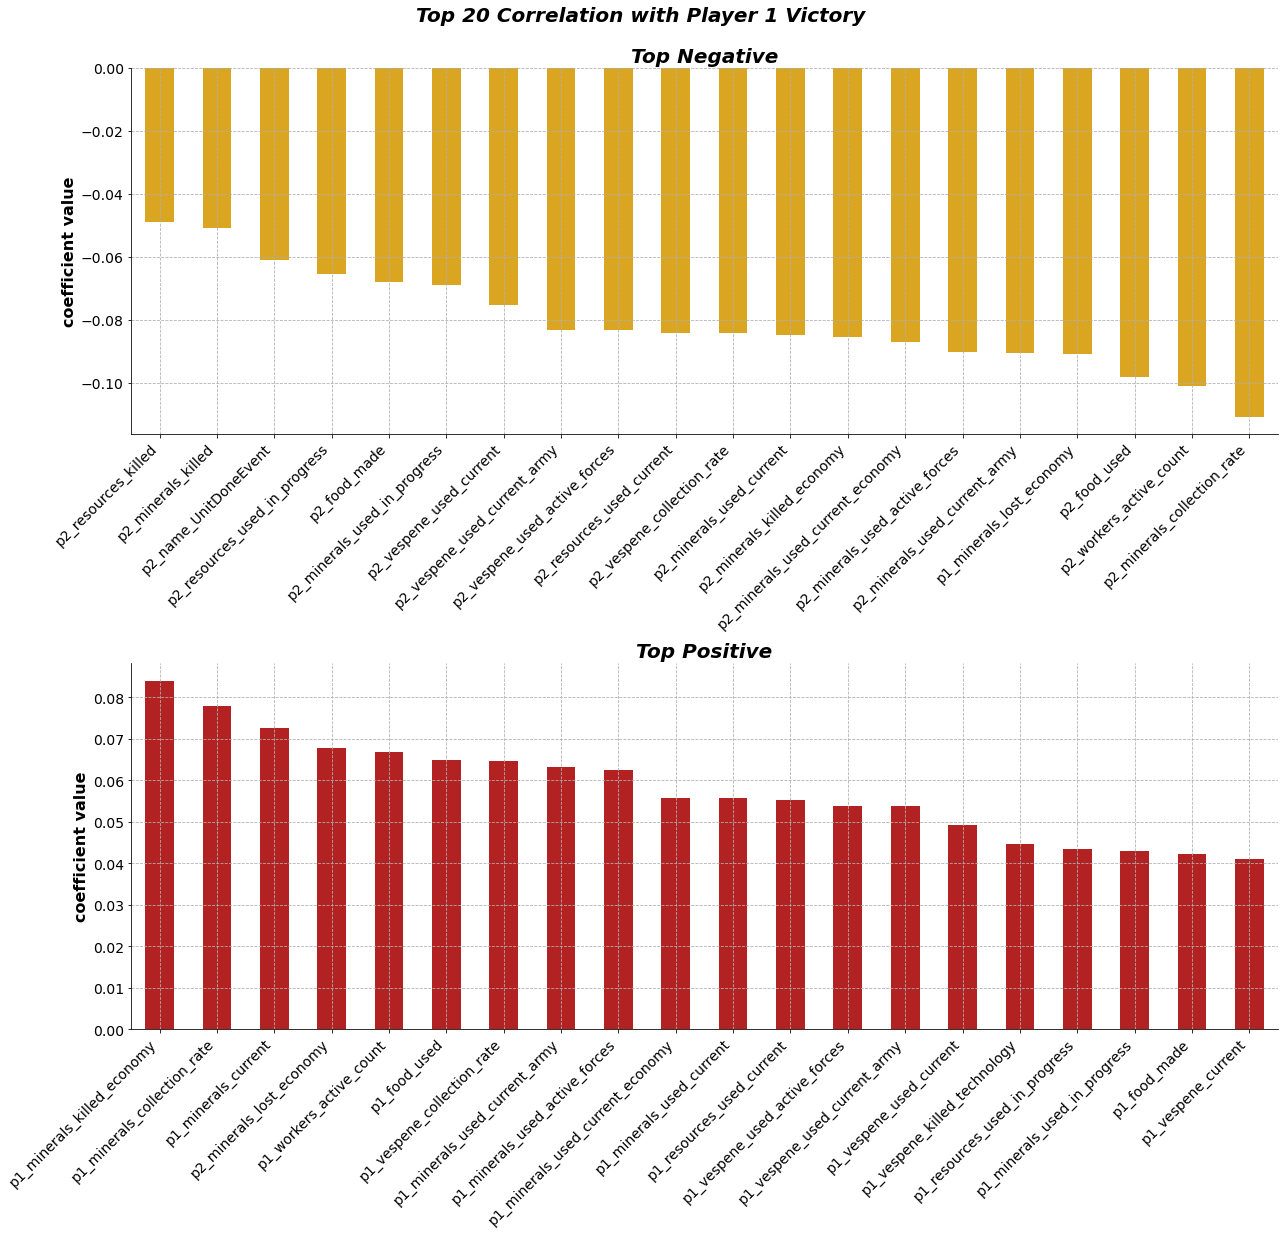

In [13]:
# drop winner row because it will always correlate to itself
train_corr = train_corr.drop('winner')

# plot the top negative and positive correlations
plot_top_n_values(train_corr, 'Correlation with Player 1 Victory')

The results of the above correlation are interesting and promising. 

The highest 5 correlations with game outcome are fitting because:
1. `p1_minerals_killed_economy` - It is always advantageous to destroy the economy of the enemy.
2. `p1_minerals_collection_rate` - Collecting minerals is one of the chief focuses of the game. Player 1 would then have more economy available to build structures, units and upgrades.
3. `p1_minerals_current` - Having more minerals allows for more spending, and more production. This one is interesting because it is a common mantra in the StarCraft community that one should "spend their money". It is considered bad play to have too large a bank of resources, as those resources are doing nothing in the bank, whereas they could be used to build structures, units and upgrades.
4. `p2_minerals_lost_economy` - Similar to reasoning to (1).
5. `p1_workers_active_count` - Having more workers means more economy, and would give Player 1 an advantage.

The highest 5 negative correlations with game outcome are:
1. `p2_minerals_collection_rate` - The inverse of (2) from the positive correlations.
2. `p2_workers_active_count` - The inverse of (5) from the positive correlations.
3. `p2_food_used` - "Food" (otherwise known as supply) is a count of the number of workers and fighting units that the player has. The more Player 2 has, the more unlikely it would be that Player 1 wins.
4. `p1_minerals_lost_economy` - The inverse of (4) from the positive correlations.
5. `p2_minerals_used_current_army` - The more expensive an army, the higher one would assume the quality would be. This would then be expected to give Player 2 an advantage.

It is interesting to note that the lists are not exact mirrors of one another. This suggests that perhaps there is some variance even in the balanced dataset that we have collected. However, it would not be practical to rework the data for each feature. Future work could perhaps focus on creating new features by measuring the difference between these mirror values (i.e. `p1_food_used` minus `p2_food_used`) instead of using the raw values.

#### Least common features

Next we will examine the most and least common features. To do this we will count the number of times a column is non-zero for each game (filehash) in train_df.

In [14]:
# use groupby to collect data into individual games
summed_df = train_df.groupby('filehash').sum()
summed_df.head()

,frame,p1_upgrade_type_name_SprayTerran,p1_upgrade_type_name_TerranInfantryWeaponsLevel1,p1_name_PlayerStatsEvent,p1_name_UnitBornEvent,p1_name_UnitDiedEvent,p1_name_UnitDoneEvent,p1_name_UpgradeCompleteEvent,p1_unit_type_name_Cyclone,p1_unit_type_name_Liberator,p1_unit_type_name_Marine,p1_unit_type_name_Medivac,p1_unit_type_name_Raven,p1_unit_type_name_SCV,p1_unit_type_name_SiegeTank,p1_unit_type_name_VikingFighter,p1_resources_used_current,p1_vespene_used_current_technology,p1_vespene_used_in_progress,p1_vespene_lost_economy,p1_vespene_killed,p1_vespene_current,p1_vespene_used_in_progress_army,p1_workers_active_count,p1_minerals_current,p1_minerals_killed_army,p1_minerals_used_current_economy,p1_vespene_lost_technology,p1_vespene_used_current_economy,p1_vespene_used_current_army,p1_vespene_lost_army,p1_vespene_killed_army,p1_food_made,p1_vespene_killed_technology,p1_resources_lost,p1_vespene_used_in_progress_economy,p1_minerals_used_current_technology,p1_minerals_used_in_progress_technology,p1_vespene_used_active_forces,p1_minerals_killed_economy,p1_minerals_used_active_forces,p1_minerals_used_current_army,p1_minerals_lost_army,p1_minerals_used_in_progress_economy,p1_food_used,p1_minerals_lost_economy,p1_vespene_used_in_progress_technology,p1_minerals_used_in_progress,p1_minerals_lost,p1_resources_used_in_progress,p1_vespene_collection_rate,p1_vespene_used_current,p1_minerals_collection_rate,p1_minerals_killed_technology,p1_vespene_lost,p1_resources_killed,p1_vespene_killed_economy,p1_minerals_lost_technology,p1_minerals_used_current,p1_minerals_used_in_progress_army,p1_minerals_killed,p2_upgrade_type_name_GraviticDrive,p2_upgrade_type_name_PhoenixRangeUpgrade,p2_upgrade_type_name_ProtossAirWeaponsLevel1,p2_upgrade_type_name_ProtossAirWeaponsLevel2,p2_upgrade_type_name_SprayProtoss,p2_upgrade_type_name_WarpGateResearch,p2_name_PlayerStatsEvent,p2_name_UnitBornEvent,p2_name_UnitDiedEvent,p2_name_UnitDoneEvent,p2_name_UpgradeCompleteEvent,p2_unit_type_name_Disruptor,p2_unit_type_name_DisruptorPhased,p2_unit_type_name_Phoenix,p2_unit_type_name_Probe,p2_unit_type_name_Stalker,p2_unit_type_name_WarpPrism,p2_unit_type_name_Zealot,p2_resources_used_current,p2_vespene_used_current_technology,p2_vespene_used_in_progress,p2_vespene_lost_economy,p2_vespene_killed,p2_vespene_current,p2_vespene_used_in_progress_army,p2_workers_active_count,p2_minerals_current,p2_minerals_killed_army,p2_minerals_used_current_economy,p2_vespene_lost_technology,p2_vespene_used_current_economy,p2_vespene_used_current_army,p2_vespene_lost_army,p2_vespene_killed_army,p2_food_made,p2_vespene_killed_technology,p2_resources_lost,p2_vespene_used_in_progress_economy,p2_minerals_used_current_technology,...,p1_unit_type_name_KrakenPod,p1_unit_type_name_Leviathan,p1_unit_type_name_LocustFlying,p1_unit_type_name_Mantis,p1_unit_type_name_SwarmHostSplitB,p2_upgrade_type_name_ProtossDNA,p2_unit_type_name_CarrierRepairDrone,p2_unit_type_name_DestructibleDebris4x4_P,p2_unit_type_name_DestructibleDebris6x6,p2_unit_type_name_DestructibleDebris6x6_P,p2_unit_type_name_Firebat,p2_unit_type_name_Goliath,p2_unit_type_name_HERC,p2_unit_type_name_MarineGunner,p2_unit_type_name_MarineResoc,p2_unit_type_name_Medic,p2_unit_type_name_Nuke2,p2_unit_type_name_Predator,p2_unit_type_name_Vulture,p1_unit_type_name_CollapsibleRockTowerPushUnitRampLeft,p1_unit_type_name_CollapsibleTerranTowerPushUnitRampLeft,p1_unit_type_name_HighTemplar,p1_upgrade_type_name_SnowVisualMP,p2_upgrade_type_name_SnowVisualMP,p2_unit_type_name_DarkTemplar,p2_unit_type_name_ForceFieldBlue,p1_upgrade_type_name_RavenRecalibratedExplosives,p1_unit_type_name_RavenRepairDrone,p1_upgrade_type_name_MicrobialShroud,p1_unit_type_name_DarkTemplar,p2_upgrade_type_name_MicrobialShroud,p2_upgrade_type_name_RavenRecalibratedExplosives,p2_unit_type_name_ReleaseInterceptorsBeacon,p2_upgrade_type_name_GhostMoebiusReactor,p2_unit_type_name_RavenRepairDrone,p1_upgrade_type_name_TerranVehicleAndShipWeaponsLevel1,p2_unit_type_name_Colla

In [15]:
# create an empty dataframe to store the counts
common_features = summed_df.astype(bool).sum(axis=0).sort_values(ascending=True)
common_features.head(15)

p2_upgrade_type_name_RavenEnhancedMunitions                     0
p1_upgrade_type_name_RavagerRange                               0
p2_upgrade_type_name_ZergMissileWeaponsLevel4                   0
p2_unit_type_name_CollapsibleRockTowerPushUnitRampRightGreen    0
p2_unit_type_name_ForceFieldRed                                 0
p1_unit_type_name_ForceFieldRed                                 0
p1_unit_type_name_CollapsibleRockTowerPushUnitRampRightGreen    0
p1_unit_type_name_KrakenPod                                     1
p1_unit_type_name_InfestorTerran                                1
p1_unit_type_name_HunterKiller                                  1
p1_unit_type_name_HotSRaptor                                    1
p1_unit_type_name_HotSHunter                                    1
p1_unit_type_name_DragonPod                                     1
p1_unit_type_name_DestructibleDebris6x6_P                       1
p1_unit_type_name_BehemothPod                                   1
dtype: int

A number of features have no representation in the training data. It might be worthwhile to remove features below a certain threshold. There are 25,547 games in total, so we will choose a threshold of 1% of the total games, which is around 250 games. 

In [16]:
# show features with values less than equal to threshold
thresh = 250
number_removed = len(common_features[common_features <= thresh])
print(f'A threshold of {thresh} would remove {number_removed} features')

A threshold of 250 would remove 186 features


These features will not be removed currently, but during modeling the functionality may be added to allow for testing the effect of removing these features on accuracy and performance. Further work on the model should investigate reducing the amount of features used.

## Section 2: Modeling with RNN <a name="section-2"></a>

In this section we will build and train an RNN model to predict the outcome of the game. Initial modeling attempts will use the first 5 minutes of every game, later attempts will use the entirety of each game, but this will involve longer training times, both because there will be more data needed (we will likely need to re-aggregate the data to larger windows) and because we will need to train the model one game at a time, increasing the run time significantly.

A generator function is used to provide the data in batches to the model. This function will allow the flexibility to modify the window size (number of frames) that we are using to train the model. The modeling plan is:
1. Run a basic model with the first 5 minutes of each game, and evaluate the performance.
2. Run the model in a loop, increasing the window size by 1 minute at a time, and evaluate the performance as time progresses. During this process we will save the model predictions for each time window, and exclude any replays that are shorter than the window size.
3. Use `Gridsearch` to test optimizations that can be made to improve model performance. For this optimization we will again use the 5 minute window, so that we can compare against the baseline from step 1.

Here we will train a simple RNN model with one layer of LSTM (long short term memory) cells. A default of 128 LSTM cells will be used, with BatchNormalization and Dropout layers added to avoid overfitting.

A basic explanation of the model architecture can be found [here](https://www.tensorflow.org/tutorials/structured_data/time_series) but a summary is included below:
* **LSTM**: LSTM is a type of recurrent neural network that is used to process time series and sequential data. It is different from a traditional neural network node in that it has feedback connections which allow it to learn patterns in the data. It was developed to be an improvement over traditional RNN, by dealing with the __[vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)__. The __[Wikipedia article](https://en.wikipedia.org/wiki/Long_short-term_memory)__ contain a summary of the LSTM use-cases, and __[this](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)__ contains more information on setup and training. The most important options are:
    * `kernel_regularizer`: Regularization to avoid overfitting.
    * `return_sequences`: If True, returns the full sequence instead of only the last output. This setting allows multiple LSTM layers to be stacked. The final LSTM layer should have this set to False.
    * `return_state`: If True, returns the last state in addition to the output. This is useful for passing the state to the next layer, and may be implemented in further modeling attempts because we are interested in predicting the state of the game.
* **BatchNormalization**: `BatchNormalization` is a technique to reduce the effect of the vanishing gradient problem by normalizing the input and output of the network.
* **Dropout**: `Dropout` is a technique to reduce overfitting by randomly dropping units from the network. Dropout of 0.2 means 20% of the units will be dropped.

The input shape of the model is (Number of Events, Number of Features) so that the model knows how to process the 3D tensor we are passing it.

The final layer of the model will always be a `Dense` layer with a single node, and the activation function will be `sigmoid`. This is because we are trying to predict the probability of the game being won by player 1, and sigmoid is the function that returns this probability, similar to how Logistic Regression works.

We use `binary_crossentropy` as the loss function as this is the standard loss function for binary classification problems. __[This post](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)__ contains an interesting exploration of binary crossentropy, but to summarize: It is a loss function that penalizes wrong predictions more the higher their probability is. In other words, if the model has 55% probability for one prediction and 80% for another, but both are wrong, the 80% probability prediction would be penalized more.

### 2.1 Extracting the Datasets <a name="section-2-1"></a>

The datasets are already available in memory (`train_df`, `val_df`, `test_df`), if not we will just rerun the code from Section 1.2 down to regenerate the datasets. During model running, our memory usage will all but double because we are loading the entire dataset into memory.

We will scale the data in all three datasets by fitting a `StandardScaler` to the training data and applying the same transformation to the validation and test data. This will prevent data leakage from validation and test sets back to the training set. Future work could explore the impact of different scaling methods on model performance.

We will then split each replay into a numpy array of aggregated frames and store these in `data/model_data/` with separate directories for train, validation and test data. These scaled data can then be directly imported into the model at runtime, allowing for larger batches and improved run times.

### 2.2 Simple RNN Model <a name="section-2-2"></a>
Here we will train a simple RNN model with one layer of LSTM (long short term memory) cells. A default of 128 LSTM cells will be used, with BatchNormalization and Dropout layers added to avoid overfitting.

#### Create BatchGenerator class
First we will create the class that will be used to generate the data for the batches in our RNN. A `batch_size` is the number of replays that are run through the model at a time. Batch sizes that are too small will greatly increase the model training time, while batch sizes that are too large will increase the memory usage.


In [29]:
%%writefile scripts/classes/BatchGenerator.py
# create the BatchGenerator class
# code based on: 
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://datascience.stackexchange.com/questions/48796/how-to-feed-lstm-with-different-input-array-sizes
from tensorflow import keras
import numpy as np
import os

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(
        self, 
        list_filehashes, 
        labels,
        data_dir,
        window_size,
        n_channels,
        batch_size=32,  
        n_classes=2, 
        shuffle=True
    ):
        """
        Generate batches of data for training.
    
        Args:
            data (str): the path to a directory of npy files
            labels (dict): a dictionary of filehashes and their corresponding labels
            list_filehashes (list): the list of filehashes to use
            window_size (int): the number of timesteps to use as a window
            n_channels (int): the number of features in the data
            batch_size (int): the number of samples per batch. Defaults to 32.
            n_classes (int): the number of classes for the target. Defaults to 2.
            shuffle (bool): whether to shuffle the data. Defaults to True.
        """
        self.data_dir = data_dir
        self.labels = labels
        self.batch_size = batch_size
        self.window_size = window_size
        self.n_channels = n_channels
        self.list_IDs = list_filehashes
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, window_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.window_size, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            # get X_tmp and then cut down to the window size
            X_tmp = np.load(os.path.join(self.data_dir, ID + '.npy'))

            X[i,] = X_tmp[:self.window_size,:]

            # Store class
            y[i] = self.labels[ID]

        return X, y



Overwriting scripts/classes/BatchGenerator.py


#### Scale and store data
We will again be using filehashes as the ID by which we identify each replay. Filenames for each replay will be stored as `\<filehash\>.npy`. 

To reference the data for a particular replay we will create a `partition` dictionary that maps train, validation, and test data to their respective filehashes. We will also create a labels dictionary that maps the filehashes to the labels (1 for player 1 win, 0 for player 2 win) for each replay.

In [18]:
# NOTE: Uncomment if running from Section 1.2, comment if starting at 2.2
# read spawningtool_df
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

# create labels dictionary from spawningtool_df
# get a dictionary of filehashes as keys and winner as values
labels = spawningtool_df[['game_winner', 'filehash']].set_index('filehash').to_dict()['game_winner']

# drop all keys with zero values from a
labels = {k: v for k, v in labels.items() if v != 0}

# convert all 2s to 0s in a
labels = {k: 0 if v == 2 else v for k, v in labels.items()}

# extract a list of feature columns
not_feature_columns = ['winner', 'filehash', 'frame']
feature_columns = [
    c for c in master_columns_list if c not in not_feature_columns
]

# # fit and transform train_df using StandardScaler
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns].values)

# transform val_df using the same scaler
val_df[feature_columns] = scaler.transform(val_df[feature_columns].values)

# transform test_df using the same scaler
test_df[feature_columns] = scaler.transform(test_df[feature_columns].values)


In [19]:
# function to loop through unique filehash in the df and output to npy
def write_npy_per_replay(
    df,
    columns,
    directory,
    filehash_column='filehash'
):
    """
    Write npy files for each replay in the dataframe, identified by the filehash.

    Args:
        df (pandas.DataFrame): the dataframe containing the data
        columns (list): the list of columns to use as features
        directory (str): the directory to write the npy files to
        filehash_column (str): the column name for the filehash. Defaults to 'filehash'.

    Returns:
        list of filehashes that were written
    """
    # list of filehashes
    filehashes = df[filehash_column].unique()

    # loop through filehashes
    for i in tqdm(
            range(len(filehashes)), 
            unit='replay'
        ):
        # get filehash
        filehash = filehashes[i]
        # create a mask to select rows with the same filehash
        mask = df[filehash_column] == filehash

        # get the dataframe with the selected filehash
        df_filehash = df.loc[mask, columns]

        # save the dataframe as a numpy array
        np.save(f'{directory}/{filehash}.npy', df_filehash[columns].values)

    return filehashes


In [20]:
# NOTE: Uncomment if running from Section 1.2, comment if starting at 2.2
# loop through dfs using write_npy_per_replay
df_list = [train_df, val_df, test_df]
directory_list = [
    'data/model_data/train',
    'data/model_data/val',
    'data/model_data/test'
]

# create the partition dictionary
partition_labels = ['train', 'val', 'test']
partition = {}

for i, df in enumerate(df_list):
    # list of filehashes
    filehashes = df['filehash'].unique()

    print(f'Writing npy files for {partition_labels[i]}')

    # write the npy files
    partition[partition_labels[i]] = write_npy_per_replay(
        df,
        feature_columns,
        directory_list[i]
    )
    
    print(f'Done with {partition_labels[i]}')
    print('-'*80)


Writing npy files for train


100%|██████████| 17885/17885 [27:52<00:00, 10.69replay/s]


Done with train
--------------------------------------------------------------------------------
Writing npy files for val


100%|██████████| 7662/7662 [05:19<00:00, 23.96replay/s]


Done with val
--------------------------------------------------------------------------------
Writing npy files for test


100%|██████████| 6388/6388 [03:46<00:00, 28.22replay/s]

Done with test
--------------------------------------------------------------------------------


In [21]:
# NOTE: Uncomment this code if running from 1.2 or comment if running from 2.2
# delete the dfs to save memory
del train_df, val_df, test_df

#### Train the model

Now that we have scaled and cleaned data and stored it in the `model_data` directory, we can train the model. We will use the `train_generator` to generate batches of data, and the `validation_generator` to generate batches of validation data.

The function `setup_data_for_modeling` can be run at the beginning of every model run to generate the list of filehashes for each partition by comparing the window size against the number of rows available in each file. This will be useful later when we loop through different window sizes and train the model.

In [8]:
def setup_data_for_modeling(
    metadata_path='data/spawningtool_replays.csv',
    master_columns_path='info/clean_master_columns_list.csv',
    non_feature_columns=['winner', 'filehash', 'frame'],
    window_size=60,
    verbose=True
):
    """
    Setup the data for modeling.
    
    Args:
        metadata_path (str): the path to the metadata csv. Defaults to 'data/spawningtool_replays.csv'.
        master_columns_path (str): the path to the master_columns_list csv. Defaults to 'info/clean_master_columns_list.csv'.
        non_feature_columns (list): the list of non-feature columns. Defaults to ['winner', 'filehash', 'frame'].
        window_size (int): the window size to use. Defaults to 60.
        verbose (bool): whether to print out the progress. Defaults to True.

    Returns tuple:
        panda.DataFrame: the dataframe containing the metadata
        list: the list of all columns
        list: the list of feature columns
        dict: the dictionary of train, val, and test filehashes
        dict: the dictionary of labels
    """
    # get spawningtool_df
    spawningtool_df = pd.read_csv(metadata_path)

    # get master_columns_list
    master_columns_list = pd.read_csv(master_columns_path).values.tolist()
    master_columns_list = [col[0] for col in master_columns_list]

    # create non_feature_columns
    non_feature_columns = ['winner', 'filehash', 'frame']
    # create feature_columns list
    feature_columns = [
        col for col in master_columns_list if col not in non_feature_columns
    ]

    # loop through files in the partitions and create a list of hashes that meet 
    # the window size
    partition = {}
    for folder in ['train', 'val', 'test']:
        # get the filenames in the folder
        filehashes = [
            os.path.splitext(f)[0] for f in os.listdir(
                f'data/model_data/{folder}'
            )
        ]

        partition_list = []
        # load the file and check its shape[0]
        for filehash in filehashes:
            arr = np.load(f'data/model_data/{folder}/{filehash}.npy')
            if arr.shape[0] > window_size:
                partition_list.append(filehash)

        # add the filehashes to the partition
        partition[folder] = partition_list

        # calculate number of files removed
        removed = len(filehashes) - len(partition_list)

        if verbose:
            print(f'\t{folder} has {len(filehashes)} valid files, removed {removed} files ({round(100*removed/len(filehashes),2)}%)')

    # construct the labels dictionary
    labels = spawningtool_df[['game_winner', 'filehash']].set_index('filehash').to_dict()['game_winner']
    # drop all keys with value == 0
    labels = {k: v for k, v in labels.items() if v != 0}
    # convert value all keys with value == 2 to 1
    labels = {k: 0 if v == 2 else 1 for k, v in labels.items()}

    return spawningtool_df, master_columns_list, feature_columns, partition, labels

In [18]:
# import class
from scripts.classes.BatchGenerator import BatchGenerator
%autoreload


In [19]:
# define window_size
window_size = 60

# set up the data for modeling
spawningtool_df, master_columns_list, feature_columns, partition, labels = setup_data_for_modeling(window_size=window_size)

# create a dictionary of parameters to pass to both generators
params = {
    'window_size': window_size, 
    'n_channels': len(feature_columns),
    'batch_size': 32, 
    'shuffle': True
}

# setup generators for training and validation
training_generator = BatchGenerator(
    partition['train'],
    labels,
    data_dir='data/model_data/train',
    **params
)

validation_generator = BatchGenerator(
    partition['val'],
    labels,
    data_dir='data/model_data/val',
    **params
)

# instantiate RNN model
model = Sequential()

# add LSTM layer
model.add(LSTM(
    units=128,
    input_shape=(window_size, len(feature_columns)),
    return_sequences=False
))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# add dense layer
model.add(Dense(
    1, 
    activation='sigmoid', 
    kernel_regularizer=keras.regularizers.l1(0.01)
))

# compile model using binary crossentropy loss and adam optimizer
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# generate a unique identifier for the model use LSTM nodes and window_size
model_file = f'models/lstm.128_ws.{window_size}'
model_file_ext = '.h5'
# check if the model file exists and if so, append a version number
if os.path.exists(model_file+model_file_ext):
    # iterate through the version number to find the next available version number
    i = 1
    model_file = model_file + '_v' + str(i)
    while os.path.exists(model_file+model_file_ext):
        i += 1
        model_file = model_file + '_v' + str(i)

# create a callback to log history
csv_logger = CSVLogger(model_file+'.csv')

# create a callback to save checkpoints
checkpoint = ModelCheckpoint(
    filepath='models/checkpoints/'+model_file.split('/')[1]+'_{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False
)

# create a callback which stops training when no improvement is being made
earlystop = EarlyStopping(
    monitor='val_loss', # monitor validation loss to prevent overfitting
    patience=2, # stop after 3 epochs without improvement
    verbose=1,  # print a message when the callback is triggered
    mode='auto' # keras infers if the monitored variable should be increasing or decreasing
)

	train has 25547 valid files, removed 27 files (0.11%)
	val has 7662 valid files, removed 5 files (0.07%)
	test has 6388 valid files, removed 3 files (0.05%)


The cell above creates the RNN model by:
* Preparing the training and validation data - we can see the number of files that were removed from each partition printed as a result of the cleaning process. This indicates that perhaps some replays which were too short slipped through our cleaning process, as 60 rows should be the minimum length of a replay when we specified that they should be 5 minutes or longer. In future work it may be worth re-working the cleaning process to be more robust.
* Creating the layers and nodes for the model. In this case we have used:
    * 1 LSTM layer with 128 LSTM cells - The nodes that will be used to process the data.
    * 1 Dropout layer with a dropout rate of 0.2 - Dropout randomly drops units from the network to prevent overfitting.
    * 1 BatchNormalization layer - This is a technique to reduce the effect of the vanishing gradient problem by normalizing the input and output of the network.
    * 1 Dense layer with a single node and sigmoid activation - This is the final layer of the model which outputs the probability of a value of 1. We can then convert this into an actual prediction by using a simple threshold, that is if the probability is greater than 0.5, we predict a value of 1, otherwise we predict a value of 0.
* Compiling the model with our chosen loss function and optimizer, and the metric of accuracy.
* Created a callback called `earlystop` which stops the model running when the validation loss (specified in the `monitor` parameter) does not improve for 2 epochs (specified in the `patience` parameter). 
* Created a callback called `csv_logger` which logs the training and validation loss and accuracy to a CSV file.
* Create a callback called `checkpoint` which saves the model weights to a file every epoch. Useful if we observe an epoch with better results than subsequent epochs.

Now we can fit the model using the below cell. The training data is handled by our `training_generator` which outputs a tuple of X and y values for each batch, and similarly the validation data is handled by our `validation_generator`.

In [336]:
# fit the model and save to history
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[earlystop, csv_logger, checkpoint]
)

# pickle the model
model.save(model_file+model_file_ext)

Epoch 1/50
797/797 [==============================] - 34s 41ms/step - loss: 0.7081 - accuracy: 0.6406 - val_loss: 0.6203 - val_accuracy: 0.6785
Epoch 2/50
797/797 [==============================] - 25s 32ms/step - loss: 0.6002 - accuracy: 0.6933 - val_loss: 0.5757 - val_accuracy: 0.7088
Epoch 3/50
797/797 [==============================] - 26s 32ms/step - loss: 0.5654 - accuracy: 0.7186 - val_loss: 0.5667 - val_accuracy: 0.7178
Epoch 4/50
797/797 [==============================] - 25s 32ms/step - loss: 0.5198 - accuracy: 0.7558 - val_loss: 0.5228 - val_accuracy: 0.7529
Epoch 5/50
797/797 [==============================] - 25s 31ms/step - loss: 0.4834 - accuracy: 0.7803 - val_loss: 0.5056 - val_accuracy: 0.7589
Epoch 6/50
797/797 [==============================] - 25s 31ms/step - loss: 0.4526 - accuracy: 0.7998 - val_loss: 0.5129 - val_accuracy: 0.7609
Epoch 7/50
797/797 [==============================] - 25s 32ms/step - loss: 0.4201 - accuracy: 0.8220 - val_loss: 0.5030 - val_accuracy:

In [13]:
# function to display the confusion matrix in a nice format
def display_confusion_matrix(
    y_true,
    y_pred,
    class_names,
    as_percentages=True,
):
    """
    display_confusion_matrix
    Display a confusion matrix created by the sklearn module as a formatted pandas dataframe with styled background and class labels.

    Args:
        y_true (array): the true labels
        y_pred (array): the predicted labels
        class_names (array): the names of the classes
        as_percentages (bool): whether to display the percentages or the counts
    Returns:
        None
    """    

    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true, y_pred)

    # create a pandas dataframe from the confusion matrix
    df_cm = pd.DataFrame(
        cm, 
        index=['True ' + v for v in class_names], 
        columns=['Pred ' + v for v in class_names]
    )

    title_string = 'Confusion Matrix'

    # convert to percentages if desired
    if as_percentages:
        # divide each cell by the sum of all cells times by 100 to percent
        df_cm = df_cm / df_cm.sum().sum() * 100
        # round the values to 2 decimal places
        df_cm = df_cm.round(2)
        # add a % sign to the column names
        df_cm.columns = ['% ' + c for c in df_cm.columns]
        # add a % sign to the row names
        df_cm.index = ['% ' + c for c in df_cm.index]
        # update the title string
        title_string = 'Confusion Matrix (Percentages)'

    print('-'*40)
    print(f'\t{title_string}')
    display(df_cm.style.background_gradient().format(precision=2))
    print('-'*40)

In [4]:
# function to reload a model from a file
def reload_keras_model(model_file):
    """
    reload_keras_model
    Reload a keras model from a file.

    Args:
        model_file (str): the model file name
    Returns:
        model (keras model): the keras model
        history (pandas.DataFame): the keras history.history object
    """    

    # remove the .h5 extension from the file name
    model_name = os.path.splitext(model_file)[0]
    ## load the model
    model = keras.models.load_model(f'models/{model_file}')
    # load the history
    history = pd.read_csv(f'models/{model_name}.csv')
    return model, history


In [20]:
# reload the best model for the charting below
model, history = reload_keras_model('lstm.128_ws.60.h5')

In [21]:
# predict on validation set

# define a new validation_generator with batch_size=1 so that all predictions are made
prediction_validation_generator = BatchGenerator(
    partition['val'],
    labels,
    data_dir='data/model_data/val',
    window_size=window_size, 
    n_channels=len(feature_columns),
    batch_size=1, 
    shuffle=False
)
# get the predictions
predictions = model.predict(prediction_validation_generator)
# convert the predictions to binary
predictions = np.where(predictions > 0.5, 1, 0)


In [22]:
# get the true labels for the set from partition
true_labels = [labels[k] for k in partition['val']]

# calculate the accuracy, precision, and recall
acc = round(
    accuracy_score(
        true_labels,
        predictions
    )*100, 
    2
)
prec = round(
    precision_score(
        true_labels,
        predictions
    )*100, 
    2
)
rec = round(
    recall_score(
        true_labels,
        predictions
    )*100,
    2
)

# calculate confusion matrix and accuracy
print(f'Model validation accuracy: {acc}%')
print(f'Model validation precision: {prec}%')
print(f'Model validation recall: {rec}%')

# plot the confusion matrix
display_confusion_matrix(
    true_labels,
    predictions,
    ['Player2 Win', 'Player1 Win']
)

Model validation accuracy: 76.58%
Model validation precision: 76.6%
Model validation recall: 81.55%


NameError: name 'display_confusion_matrix' is not defined

#### 
Our simple model performed well, predicting the outcome of the game with an accuracy of around 75%. The confusion matrix shows around 12% of both false negatives and false positives (i.e. predicted Player 2 victory when Player 1 won and vice versa).

* __[Precision Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)__: True positives divided by total true and false positives. This is a measure of how correct the model is in its predictions of Player 1 winning, that is how sure we are that a predicted value of 1 is indeed a 1
* __[Recall Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall%20score#sklearn.metrics.recall_score)__: True positives divided by total true and false negatives. This is true Player 1 wins we missed, as a false negative would be a missed Player 1 victory. This a measure of how many true Player 1 wins we have predicted.

Because we are trying to predict both 0 and 1 correctly, Recall and Precision would have to be applied to both 0 and 1 predictions. In other words, we would calculate the Precision and Recall for the original predictions (1 is Player 1 winning) and then swap 0 and 1 values to do the same for Player 2.

We will set up a function to perform this calculation for us.

In [15]:
# function to calculate precision and recall for both players
def calculate_precision_recall(true_y, pred_y, print_results=True):
    """
    calculate_precision_recall
    Calculate the precision and recall for both players.

    Args:
        true_y (array): the true labels
        pred_y (array): the predicted labels
        print_results (bool): whether to print the results or not
    Returns:
        tuple: the precision and recall for both players
    """    

    # calculate precision and recall for player 1
    p1_precision = round(
        precision_score(
            true_y,
            pred_y,
            pos_label=1
        )*100,
        2
    )
    p1_recall = round(
        recall_score(
            true_y,
            pred_y,
            pos_label=1
        )*100,
        2
    )
    # calculate precision and recall for player 2
    p2_precision = round(
        precision_score(
            true_y,
            pred_y,
            pos_label=0
        )*100,
        2
    )
    p2_recall = round(
        recall_score(
            true_y,
            pred_y,
            pos_label=0
        )*100,
        2
    )

    if print_results:
        # print the results
        output = pd.DataFrame(
            {
                'Player 1': [p1_precision, p1_recall],
                'Player 2': [p2_precision, p2_recall]
            },
            index=['Precision (%)', 'Recall (%)']
        )

        print('Precision and Recall for both players')
        display(output.style.format(precision=2))
    
    return (p1_precision, p1_recall), (p2_precision, p2_recall)
    

In [322]:
# test the output of the function
_ = calculate_precision_recall(
    true_labels,
    predictions
)

Precision and Recall for both players


,Player 1,Player 2
Precision (%),76.60,76.56
Recall (%),81.55,70.76


The model performs better, in general, for Player 1, this is interesting as it means that the model is more likely to predict Player 1 wins when it is actually Player 2 winning. We will monitor this as we continue attempting to improve the model.

#### Evaluate the model
First we will evaluate the performance of the model through the epochs. We can use the `history` object to see the train and validation accuracy for each epoch. This is useful for determining where the model begins to overfit, that is where train accuracy increases while validation accuracy does not.


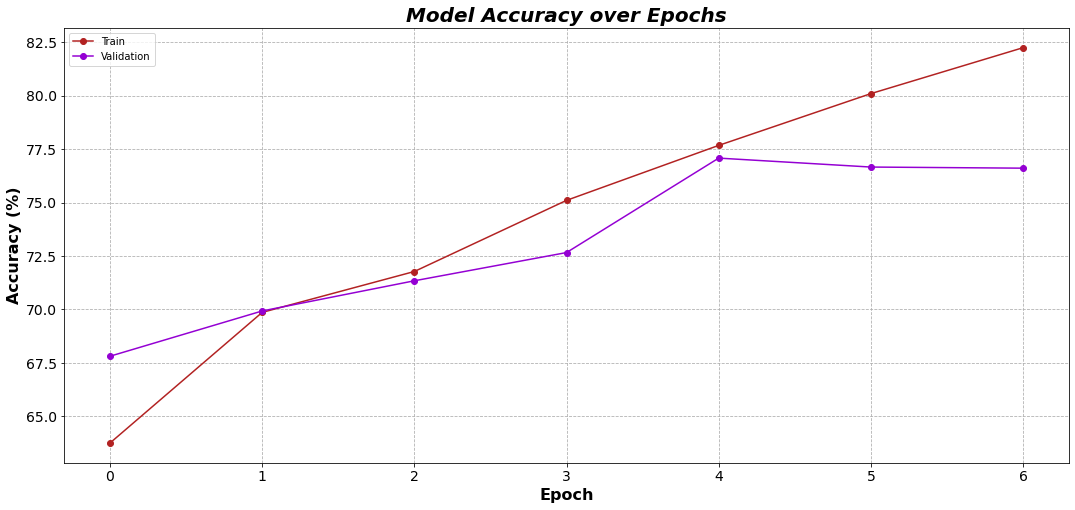

In [323]:
# plot accuracy for train and validation from history
plt.figure()
plt.plot(
    [x*100 for x in history.history['accuracy']], # to percent
    marker='o', 
    color=list(COLOR_DICT.values())[1], 
    label='Train'
)
plt.plot(
    [x*100 for x in history.history['val_accuracy']], # to percent
    marker='o',
    color=list(COLOR_DICT.values())[-1],
    label='Validation'
)
plt.title('Model Accuracy over Epochs', style='italic')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()



We can drill down into the prediction made by the model to see what is affecting model correctness. To do this we will compare the performance of the model to the percentage of each game that was modeled.

This model was trained using a window size of 60, where each window is 112 frames (this aggregation was performed in Notebook 1). So the window is 5 minutes of real-time, dividing this by the actual game length for each replay gives us the percentage modeled.

Below results are batched into 5% bins, and the average accuracy of each bin is calculated. This average accuracy is plotted against the percentage modeled.

In [324]:
# construct a df indexed by filehash and note whether prediction was wrong or right
prediction_results = pd.DataFrame({
    'filehash': [k for k in partition['val']],
    'is_correct': [1 if true_labels[i] == predictions[i] else 0 for i in range(len(true_labels))]
})
# set the index to filehash
prediction_results.set_index('filehash', inplace=True)
prediction_results.head()

,is_correct
filehash,
0016ddd5b36473f259ba8630c6c0047540a6858071737e8f890358d3f7ad355d,1
00283dcee1b0bec45ff654a0df06248d9f69a5c3a66e7827e10660ad88bf5bee,0
0033334e86cb352b0131027e58effa23adb23cf1cdd90d5760cc62254611c99a,1
0055f4541fe30a72e964fc168db7abef35822d27e4cdce8ef0adb8b3cba51b7d,1
005ac860a39ec7ae855a22b68f13ea17c1d7006bafe381e46cd9f2cbf3fa3a99,1


In [325]:
# add spawningtool_df columns to prediction_results
prediction_results = spawningtool_df.drop(
    columns=['filename', 'map']
).set_index('filehash').join(prediction_results).copy()

# drop all NaN in the is_correct column generated by joining 
prediction_results.dropna(subset=['is_correct'], inplace=True)
display(prediction_results.head())
prediction_results.shape
# only the predicted rows remain

,player1_race,player2_race,player1_mmr,player2_mmr,game_length,game_type,game_speed,game_winner,timestamp,fps,is_ladder,region,player1_highest_league,player2_highest_league,is_correct
filehash,,,,,,,,,,,,,,,
5028bd2d9b5487d8743b616d7688123d4e834cb64eceea9eabb79d1973f43b98,Protoss,Zerg,3206.0,3200.0,567,1v1,Faster,2,2021-10-07 00:28:52,16.0,True,us,4,5,0.0
f15a6f6f041821a5984dcc459b0c77833b40f01f6b969a116bfac5d3e7517f2b,Protoss,Zerg,2433.0,2325.0,307,1v1,Faster,2,2021-09-29 16:44:12,16.0,True,eu,6,2,1.0
762d8b159e51a45009293c240dfa8c177e3cc2a75dfbb131e116b57ada0dae52,Zerg,Protoss,NaN,NaN,627,1v1,Faster,1,2021-07-31 11:01:49,16.0,False,us,0,0,1.0
a295fdf291388885e7f74d8badc652f94e37942cc37408329629c28eddaafacd,Zerg,Protoss,NaN,NaN,481,1v1,Faster,2,2021-08-01 11:04:15,16.0,False,us,0,0,0.0
118f4e9b8337cb0914eff13a868a977e4e764b8196661a68b8dd77ca497cd6bf,Protoss,Protoss,NaN,NaN,650,1v1,Faster,2,2021-09-07 14:28:28,16.0,False,us,0,0,1.0


(7657, 15)

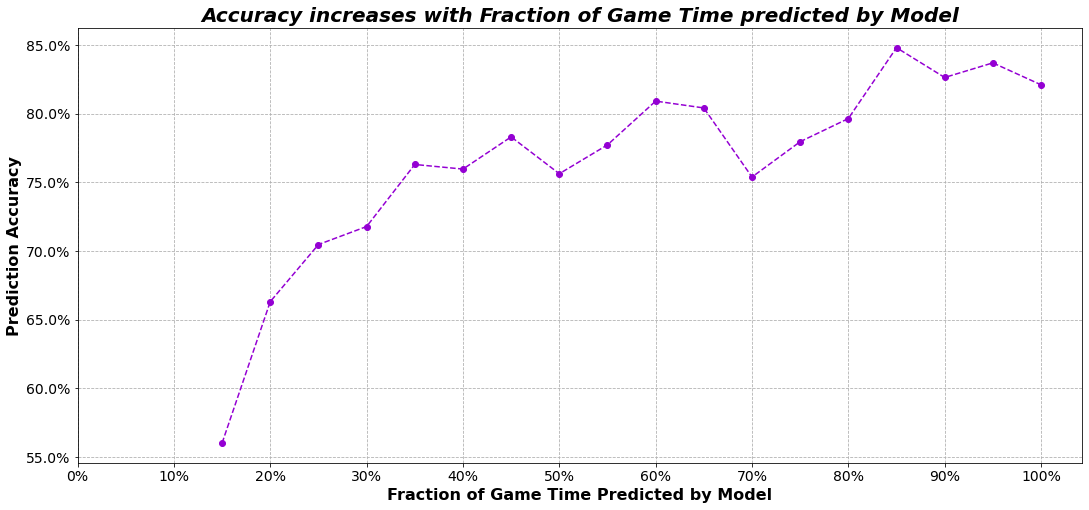

In [326]:
# calculate model_time in seconds
# each row is 112 frames and each frame is 1/22.4 seconds
model_time = window_size * 112 / 22.4

# create bins for the elapsed_percent column of every 5%
bins = np.linspace(0, 1, 21)

# create a series of the mean of is_correct as percent for each bin
prediction_results_mean = prediction_results['is_correct'].groupby(
    pd.cut(
        model_time / prediction_results['game_length'], # in percent
        bins
    )
).mean()

# convert bins in index to numeric values of their upper bound
prediction_results_mean.index = bins[1:]

# plot 
fig, ax = plt.subplots()
prediction_results_mean.plot(
    kind='line', 
    marker='o',
    linestyle='--', 
    color=list(COLOR_DICT.values())[-1]
)
plt.xlabel('Fraction of Game Time Predicted by Model')
plt.ylabel('Prediction Accuracy')
plt.title(
    'Accuracy increases with Fraction of Game Time predicted by Model', 
    style='italic'
)
# make xticks every second bin,
plt.xticks(bins[::2])
# convert labels to percentages
# suppress warnings about FixedFormatter
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x_labs = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(l) for l in x_labs])
    y_labs = ax.get_yticks()
    ax.set_yticklabels(['{:,.1%}'.format(l) for l in y_labs])

plt.show()



As would be expected, model accuracy is better the more of the game that is modeled. For games where only 15 to 20% of the game was modeled (i.e. games of 25 to 33.3 minutes) accuracy was around 67%; while where 85 to 90% of the games was modeled (i.e. games of length 5.6 to 5.9 minutes) it was around 84%.

### 2.3 Modeling with Different Window Sizes <a name="section-2-3"></a>

Now that we have proven that our model can predict game outcomes somewhat acceptably with a fixed window of 5 minutes, we will test what the effect of different window sizes is on the model. To do this we will create a function that does what Section 2.2 did, but varies window sizes. At the end of each iteration we will update the prediction_results dataframe with the results of the model. We can then plot the accuracy for each run on a plot similar to the one above, and see how the accuracy changes with the window size.

In [5]:
# function to create, train, evaluate, and save a model for a given window size
def train_evaluate_model(
    window_size,  
    save_models=True,
    verbose=1
):
    """
    train_evaluate_model
    Train, evaluate, and save a model for a given window size.

    Args:
        window_size (int): the window size to use
        save_models (bool): whether to save the models to file or not

    Returns:
        tuple: model, history, model_file, score, prediction_results
    """

    # import class
    from scripts.classes.BatchGenerator import BatchGenerator
    %autoreload

    print('\tSetting up model data...')
    # setup the model
    # set up the data for modeling
    spawningtool_df, master_columns_list, feature_columns, partition, labels = setup_data_for_modeling(window_size=window_size)

    # create a dictionary of parameters to pass to both generators
    params = {
        'window_size': window_size, 
        'n_channels': len(feature_columns),
        'batch_size': 32, 
        'shuffle': True
    }

    # setup generators for training and validation
    training_generator = BatchGenerator(
        partition['train'],
        labels,
        data_dir='data/model_data/train',
        **params
    )

    validation_generator = BatchGenerator(
        partition['val'],
        labels,
        data_dir='data/model_data/val',
        **params
    )

    print('\tCreating model architecture...')
    # instantiate RNN model
    model = Sequential()

    # add LSTM layer
    model.add(LSTM(
        units=128,
        input_shape=(window_size, len(feature_columns)),
        return_sequences=False
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # add dense layer
    model.add(Dense(
        1, 
        activation='sigmoid', 
        kernel_regularizer=keras.regularizers.l1(0.01)
    ))

    # compile model using binary crossentropy loss and adam optimizer
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # generate a unique identifier for the model use LSTM nodes and window_size
    model_file = f'models/lstm.128_ws.{window_size}'
    model_file_ext = '.h5'
    # check if the model file exists and if so, append a version number
    if os.path.exists(model_file+model_file_ext):
        # iterate through the version number to find the next available version number
        i = 1
        model_file = model_file.split('_v')[0] + '_v' + str(i)
        while os.path.exists(model_file+model_file_ext):
            i += 1
            model_file = model_file + '_v' + str(i)

    # create a callback to log history
    csv_logger = CSVLogger(model_file+'.csv')

    # create a callback to save checkpoints
    checkpoint = ModelCheckpoint(
        filepath='models/checkpoints/'+model_file.split('/')[1]+'_{epoch:02d}-{val_loss:.2f}.hdf5',
        monitor='val_loss',
        verbose=0,
        save_best_only=False
    )

    # create a callback which stops training when no improvement is being made
    earlystop = EarlyStopping(
        monitor='val_loss', # monitor validation loss to prevent overfitting
        patience=2, # stop after 3 epochs without improvement
        verbose=1,  # print a message when the callback is triggered
        mode='auto' # keras infers if the monitored variable should be increasing or decreasing
    )

    # set up callbacks to be used for training
    if save_models:
        callbacks = [earlystop, csv_logger, checkpoint]
    else:
        callbacks = [earlystop, csv_logger]

    print('\tTraining model...')
    # fit the model and save to history
    history = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks,
        verbose=verbose
    )

    if save_models:   
        # pickle the model
        model.save(model_file+model_file_ext)

    # get the last value for val_accuracy
    score = history.history['val_accuracy'][-1]

    print('\tGenerating predictions...')
    # create a generator for predictions
    prediction_generator = BatchGenerator(
        partition['val'],
        labels,
        data_dir='data/model_data/val',
        window_size=window_size, 
        n_channels=len(feature_columns),
        batch_size=1, 
        shuffle=False
    )

    # make predictions
    predictions = model.predict(prediction_generator)
    # convert predictions to binary
    predictions = np.where(predictions > 0.5, 1, 0)

    # get the true labels for the predictions
    true_labels = [labels[k] for k in partition['val']]

    # create the prediction_results dataframe
    prediction_results = pd.DataFrame({
        'filehash': partition['val'],
        'is_correct': [1 if p == l else 0 for p, l in zip(predictions, true_labels)],
    })

    # set the filehash as the index
    prediction_results.set_index('filehash', inplace=True)

    # return the model and the score
    return model, history, model_file, score, prediction_results


In [9]:
# NOTE: This cell will take at least 30 minutes to run depending on your machine.
best_score = 0
window_list = [12, 24, 48, 72, 96, 144, 192, 288]
for i, window_size in enumerate(window_list):

    print(f'Train model with window size of {window_size} (Run {i+1}/{len(window_list)})')
    # train and evaluate the model
    model, history, model_file, score, new_pred_results = train_evaluate_model(
        window_size=window_size,
        save_models=True,
        verbose=0
    )
    
    # save the model if it has the best score
    if score > best_score:
        best_score = score
        best_model = model
        best_window_size = window_size
        best_model_file = model_file
        best_history = history

    print('\tUpdating prediction results...')
    # rename is_correct to window_size
    new_pred_results.rename(columns={'is_correct': window_size}, inplace=True)
    # update the prediction_results dataframe
    if i == 0:
        prediction_results = new_pred_results
    else:
        prediction_results = pd.concat([prediction_results, new_pred_results])

    print('\tModel validation accuracy: {:.2%}'.format(score))
    print('\tModel file: {}'.format(model_file))
    print('Done!')
    print('-'*80)

prediction_results.head()

Train model with window size of 12 (Run 1/8)
	Setting up model data...
	train has 25547 valid files, removed 1 files (0.0%)
	val has 7662 valid files, removed 0 files (0.0%)
	test has 6388 valid files, removed 0 files (0.0%)
	Creating model architecture...
	Training model...
Epoch 00009: early stopping
	Generating predictions...
	Updating prediction results...
	Model validation accuracy: 57.23%
	Model file: models/lstm.128_ws.12_v1_v2_v3_v4
Done!
--------------------------------------------------------------------------------
Train model with window size of 24 (Run 2/8)
	Setting up model data...
	train has 25547 valid files, removed 1 files (0.0%)
	val has 7662 valid files, removed 0 files (0.0%)
	test has 6388 valid files, removed 0 files (0.0%)
	Creating model architecture...
	Training model...
Epoch 00011: early stopping
	Generating predictions...
	Updating prediction results...
	Model validation accuracy: 64.11%
	Model file: models/lstm.128_ws.24_v1_v2_v3
Done!
--------------------

,12,24,48,72,96,144,192,288
filehash,,,,,,,,
0016ddd5b36473f259ba8630c6c0047540a6858071737e8f890358d3f7ad355d,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00283dcee1b0bec45ff654a0df06248d9f69a5c3a66e7827e10660ad88bf5bee,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0033334e86cb352b0131027e58effa23adb23cf1cdd90d5760cc62254611c99a,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0055f4541fe30a72e964fc168db7abef35822d27e4cdce8ef0adb8b3cba51b7d,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005ac860a39ec7ae855a22b68f13ea17c1d7006bafe381e46cd9f2cbf3fa3a99,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have successfully completed the modeling set. Now we will visualize the data by plotting the Fraction of Game Time chart again for each of the time windows.

In [11]:
spawningtool_df = pd.read_csv('data/spawningtool_replays.csv')

<Figure size 1440x432 with 0 Axes>

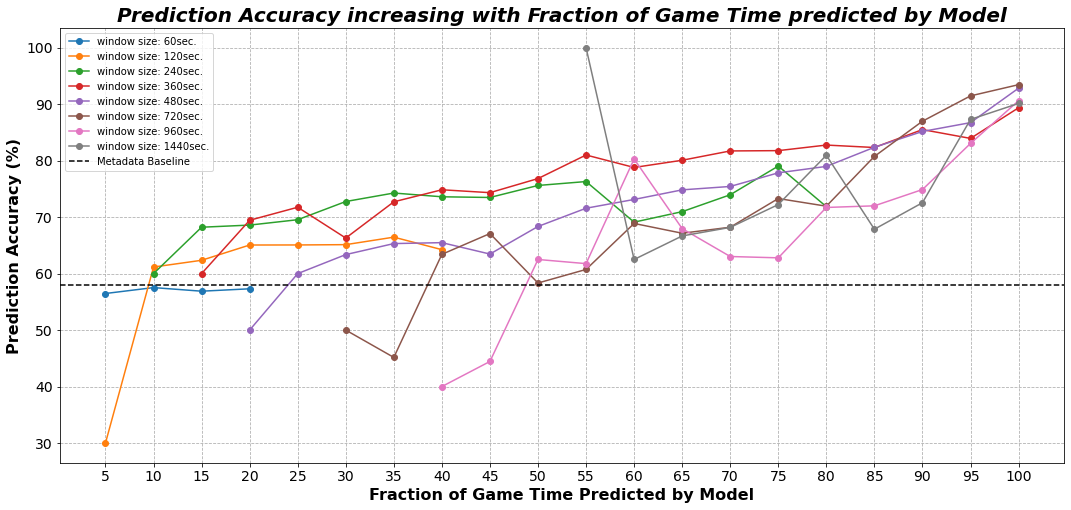

In [24]:
# create empty dataframe indexed by 5% bins
time_window_results = pd.DataFrame(index=np.linspace(5, 100, 20))

for window_size in window_list:

    # extract the list of filehashes with non NaN values
    filehashes = prediction_results[prediction_results[window_size].notna()].index.tolist()

    # create a mask for the filehashes in spawningtool_df
    mask = spawningtool_df['filehash'].isin(filehashes)

    # get the game length for each filehash from the metadata
    game_lengths = spawningtool_df.loc[
        mask, ['game_length', 'filehash']
    ].set_index('filehash')

    # calculate the fraction of game time predicted by the model
    window_length = window_size * 112 / 22.4
    percent_time_predicted = window_length / game_lengths * 100 # in percent

    # merge prediction_results[window_size] with percent_time_predicted
    percent_time_predicted = percent_time_predicted.merge(
        prediction_results[window_size].dropna(),
        left_index=True,
        right_index=True)

    # group by bins of 5% and calculate the mean of window_size
    percent_time_predicted = percent_time_predicted.groupby(
        pd.cut(
            percent_time_predicted['game_length'],
            np.linspace(0, 100, 21)
        )
    )[window_size].mean().multiply(100) # in percent

    time_window_results[window_size] = percent_time_predicted

# rename the columns to be more descriptive
time_window_results.columns = [
    f'window size: {ws*5}sec.' for ws in time_window_results.columns
]

# plot the results
plt.figure(figsize=(20, 6))
time_window_results.plot(
    kind='line',
    marker='o'
)
plt.xlabel('Fraction of Game Time Predicted by Model')
plt.ylabel('Prediction Accuracy (%)')
plt.title(
    'Prediction Accuracy increasing with Fraction of Game Time predicted by Model',
    style='italic'
)
# add horizontal line to show the metadata baseline
plt.axhline(y=58, color='black', linestyle='--', label='Metadata Baseline')
plt.legend()
plt.xticks(np.linspace(5, 100, 20))
plt.show()


The plot above gives the accuracy of the model for each window size as a function of the percentage of the game that was modeled. With the exception of a few outliers in cases where only a few games were modeled, the trend is always increasing as Fraction of Game Time increases.

As would be expected models with short windows, i.e. models that only consider the first few minutes of the game, are less accurate than those that consider more of the game. Counter-intuitively, the longest running model (window size of 288) performs the worst. This could be because of two reasons:
* The dataset was significantly smaller for this window size (4% of the original size), meaning that there is generally less data to model.
* Longer games could be harder to predict, either because the model is exposed to less of them, or because they imply an "abnormal" game state.

This implies that in production, we would train many models, perhaps at 1 minute intervals, and switch dynamically between the models as the game progresses to give the best prediction for that time window. For this we would possibly need more data collection, and a specific focus on collecting longer replays.

### 2.4 Building a Grid Search <a name="section-2-4"></a>

To optimize the hyperparameters of the model, we could retry multiple times with different hyperparameters (such as number of LSTM cells, dropout rate, learning rate, etc) and then running the model on each of these combinations. This would require significantly more time, and we would have to manually reset the hyperparameters each time.

However, Scikit-Learn has a built-in `GridSearchCV` class that can be used to do this for us. This class will automatically run the model with different hyperparameters and return the best model. In order to use GridSearchCV we will be following the guide outlined __[here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)__ (**Note**: The `KerasClassifier` used in this post has since been deprecated. `scikeras.wrappers.KerasClassifier` is used here instead). 

The basic outline of the process is:
1. Define a `create_model()` function that returns a model which we can pass to `GridSearchCV`.
2. Use the `KerasClassifier` class to create a `GridSearchCV` object with the `create_model()` function.
3. Define a dictionary of hyperparameters over which we want to search.
4. Run the `GridSearchCV` object.

#### 2.3.1 Defining the model

Below we have created a function that returns the model. The function allows for the optimization of:
* Number of nodes per layer.
* Number of hidden layers.
* Type of node (LSTM or GRU).
* Dropout rate.
* Learning rate.
* Optimizer (Adam, RMSprop, or Adagrad).

The function always adds a Dense layer, with a single node, and sigmoid activation, as this will always be the final output for the model.

Now we can use KerasClassifier to create a GridSearchCV object.

In [9]:
# initialize

# import class
from scripts.classes.BatchGenerator import BatchGenerator
%autoreload

window_size = 60

spawningtool_df, master_columns_list, feature_columns, partition, labels = setup_data_for_modeling(window_size=window_size)

# create a dictionary of parameters to pass to both generators
params = {
    'window_size': window_size, 
    'n_channels': len(feature_columns),
    'batch_size': 32, 
    'shuffle': True
}

# setup generators for training and validation
training_generator = BatchGenerator(
    partition['train'],
    labels,
    data_dir='data/model_data/train',
    **params
)

validation_generator = BatchGenerator(
    partition['val'],
    labels,
    data_dir='data/model_data/val',
    **params
)

# generate a unique identifier for the model use LSTM nodes and window_size
model_file = f'models/lstm.128_ws.{window_size}'
model_file_ext = '.h5'
# check if the model file exists and if so, append a version number
if os.path.exists(model_file+model_file_ext):
    # iterate through the version number to find the next available version number
    i = 1
    model_file = model_file + '_v' + str(i)
    while os.path.exists(model_file+model_file_ext):
        i += 1
        model_file = model_file + '_v' + str(i)

# create a callback to log history
csv_logger = CSVLogger(model_file+'.csv')

# create a callback to save checkpoints
checkpoint = ModelCheckpoint(
    filepath='models/checkpoints/'+model_file.split('/')[1]+'_{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False
)

# create a callback which stops training when no improvement is being made
earlystop = EarlyStopping(
    monitor='val_loss', # monitor validation loss to prevent overfitting
    patience=2, # stop after 3 epochs without improvement
    verbose=1,  # print a message when the callback is triggered
    mode='auto' # keras infers if the monitored variable should be increasing or decreasing
)

	train has 25547 valid files, removed 27 files (0.11%)
	val has 7662 valid files, removed 5 files (0.07%)
	test has 6388 valid files, removed 3 files (0.05%)


In [11]:
def _make_lstm(model, nodes, dropout, shape):
    """
    _make_lstm
    Create a LSTM model with the given parameters.

    Args:
        nodes (list, int): the number of nodes in each hidden layer
        dropout (float): the dropout rate
    
    Returns:
        model (keras.models.Sequential): the LSTM model
    """

    for i, number_nodes in enumerate(nodes):
        if i == 0:
            model.add(LSTM(
                number_nodes,
                input_shape=(shape[0], shape[1]),
                return_sequences=True
            ))
        elif i == len(nodes) - 1:
            model.add(LSTM(
                number_nodes,
                return_sequences=False
            ))
        else:
            model.add(LSTM(
                number_nodes,
                return_sequences=True
            ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    return model


def _make_gru(model, nodes, dropout, shape):
    """
    _make_gru
    Create a GRU model with the given parameters.

    Args:
        nodes (list, int): the number of nodes in each hidden layer
        dropout (float): the dropout rate
    
    Returns:
        model (keras.models.Sequential): the GRU model
    """

    for i, number_nodes in enumerate(nodes):
        if i == 0:
            model.add(GRU(
                number_nodes,
                input_shape=(shape[0], shape[1]),
                return_sequences=True
            ))
        elif i == len(nodes) - 1:
            model.add(GRU(
                number_nodes,
                return_sequences=False
            ))
        else:
            model.add(GRU(
                number_nodes,
                return_sequences=True
            ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    return model


def get_model(
    nodes,
    learning_rate,
    dropout_rate,
    node_type,
    shape
):

    if node_type == 'lstm':
        model = _make_lstm(
            model=Sequential(),
            nodes=nodes,
            dropout=dropout_rate,
            shape=shape
        )
    elif node_type == 'gru':
        model = _make_gru(
            model=Sequential(),
            nodes=nodes,
            dropout=dropout_rate,
            shape=shape
        )
    else:
        raise(ValueError('Node type not recognized'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


In [20]:
param_grid = {
    'nodes': [[128], [32, 32, 32]],
    'dropout_rate': [0.1,  0.5],
    'learning_rate': [0.001, 0.1],
    'node_type': ['lstm', 'gru']
}    

# get the shape of the data
shape = (training_generator.n_channels, training_generator.window_size)

rnn = KerasClassifier(
    build_fn=get_model,
    shape=shape,
    epochs=20,
    batch_size=128,
    callbacks=[earlystop, checkpoint, csv_logger],
    nodes=[128],
    dropout_rate=0.2,
    learning_rate=0.001,
    node_type='lstm',
    verbose=3
)

grid = GridSearchCV(
    estimator=rnn,
    param_grid=param_grid,
    verbose=3,
    scoring='accuracy',
    cv=3
)

grid.fit(
    training_generator,
    validation_data=validation_generator
)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[128];, score=nan total time=  13.7s
[CV 2/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[128];, score=nan total time=  13.8s
[CV 3/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[128];, score=nan total time=  17.9s
[CV 1/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[32, 32, 32];, score=nan total time=  13.6s
[CV 2/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[32, 32, 32];, score=nan total time=  13.6s
[CV 3/3] END dropout_rate=0.1, learning_rate=0.001, node_type=lstm, nodes=[32, 32, 32];, score=nan total time=  17.7s
[CV 1/3] END dropout_rate=0.1, learning_rate=0.001, node_type=gru, nodes=[128];, score=nan total time=  13.7s
[CV 2/3] END dropout_rate=0.1, learning_rate=0.001, node_type=gru, nodes=[128];, score=nan total time=  13.5s
[CV 3/3] END dropout_rate=0.1, l

C:\Users\jared\anaconda3\envs\tflow2\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jared\anaconda3\envs\tflow2\lib\site-packages\sklearn\model_selection\_validation.py", line 679, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Users\jared\anaconda3\envs\tflow2\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan n

TypeError: fit() missing 1 required positional argument: 'y'

The model run times above show that the model is not, in fact, running, which is confirmed by the error message. This seems to be a problem with how `GridSearchCV` handles the training and validation generator objects. Research into the topic (such as __[this post](https://stackoverflow.com/a/50174077/16854204)__) gives potential solutions. Such as building the data generation function into the `KerasClassifier` object.

Improving the model using `GridSearchCV` will be a good starting point for future work. However, the current discussion will be based on the proof of concept established by the simple RNN model prepared in Section 2.2. 

---

---

## Conclusion <a name="section-3"></a>
Learnings:
* A simple RNN model with 1 hidden layer of 128 cells, a dropout rate of 0.2 and a learning rate of 0.001 was able to <a style="color:darkviolet"><b>predict the outcome of the game with an accuracy of around 75%</b></a>.
* Model accuracy is a function of the fraction of the game predicted, ranging from 80% at 80% of the games length, down to the baseline of 55% at 15% of the games length.
* The RNN model is a significant improvement over the Metadata model developed in Notebook 2.

When predicting an unseen game, the model would be ignorant of the percentage of the game that has elapsed. For implementation of a live prediction (as is one of the broader goals of this work), it would be necessary to train several models, each with a different time window. Then as the game progresses, the app would switch between these models to give the best prediction available at that time.

To summarize, in this Notebook we have:
* Converted cleaned data from Notebook 1 into numpy arrays, stored for each game.
* Explored the most important features of the data in terms of linear correlation to the outcome.
* Created a data generator to dynamically generate training and validation data as the RNN model runs.
* Successfully trained an RNN model to predict game outcomes at a higher accuracy than a Metadata model could achieve.

Future work:
* Create a `GridSearchCV` methodology to optimize the architecture of the model.
* Investigate how to best predict live games, either through dynamic switching between models, or by some other means.
* Implementation of a live application that could be used by the 500,000 StarCraft II players to improve their playstyles without needing to spend $80 an hour.